Cell 1: Load libraries and dataset from S3

In [1]:
# Cell 1: Load libraries and dataset from S3

import boto3        # import boto3 to connect to AWS S3
import pandas as pd # import pandas for data handling

bucket = "ai-bmi-predictor"                 # name of the S3 bucket
key = "test-data/eff_testingA.csv"         # path to the CSV file inside the bucket

s3 = boto3.client("s3")                    # create an S3 client using your AWS credentials
obj = s3.get_object(Bucket=bucket, Key=key)  # download the S3 object that contains the CSV file

data = pd.read_csv(obj["Body"])           # read the CSV content from the S3 object body into a DataFrame

data.head()                               # display the first few rows to confirm the data loaded correctly


,photo_id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,hip,leg-length,shoulder-breadth,shoulder-to-crotch,thigh,waist,wrist,gender,height_cm,weight_kg
0,e5ae8fe5bbdf611a1e8d06e66e849bdf,0.073159,0.085775,-0.133776,0.881202,0.214236,0.016104,-0.180302,-0.100713,-0.117249,...,106.774690,83.279744,39.922305,70.005128,55.945992,98.250390,20.187082,male,180.00,94.60
1,605a5fd09058c48156b0ef518b63b2de,0.092031,-0.066016,-0.145132,0.687441,0.186508,-0.075221,-0.093846,-0.035840,0.033903,...,102.481633,84.876529,39.974203,73.591637,55.397032,88.003618,17.715785,male,188.90,86.75
2,909c9277309e13ee014e347603aba620,0.057046,-0.051366,-0.148253,0.675916,0.209973,-0.073485,-0.072783,-0.059395,0.008370,...,99.342301,82.275874,36.059983,66.440526,53.742692,82.100598,17.086464,male,179.70,73.85
3,bef6a68bc8dd475c124f6de2413385d3,-0.018792,0.016435,-0.148091,0.464433,0.242849,-0.106556,0.001489,-0.083478,0.096048,...,101.770144,76.081842,34.071748,62.218026,52.396573,83.999124,16.299751,female,166.95,69.05
4,6d7ed4bc4a17546447efed0ca6e2ff11,0.084419,0.065945,-0.153379,0.635377,0.285274,-0.056372,-0.139008,-0.120711,-0.002466,...,94.707063,81.328892,36.834735,64.426273,49.895157,86.020117,16.531431,male,173.20,65.55


Cell 2: Compute BMI

In [2]:
# Cell 2: Compute BMI (using original height and weight) and store it in the dataset

data["BMI"] = data["weight_kg"] / ((data["height_cm"] / 100) ** 2)  # calculate BMI and save as a new column
data["BMI"].describe()                                              # quickly inspect BMI statistics

count    1684.000000
mean       24.056672
std         4.147934
min        16.019762
25%        21.851282
50%        23.221269
75%        25.538605
max        37.510454
Name: BMI, dtype: float64

In [3]:
# Check the original category -> code mapping for gender
cat = data["gender"].astype("category")

print("Categories in order:", list(cat.cat.categories))
print("Category -> code mapping:", {c: i for i, c in enumerate(cat.cat.categories)})

# Optional: view a few encoded examples side-by-side (before encoding)
# If you've already encoded and lost the original strings, skip this part.
# Otherwise:
# tmp = data.copy()
# tmp["gender_cat"] = tmp["gender"].astype("category")
# tmp["gender_code"] = tmp["gender_cat"].cat.codes
# print(tmp[["gender", "gender_code"]].head(10))


Categories in order: ['female', 'male']
Category -> code mapping: {'female': 0, 'male': 1}


Cell 3: Categorical encoding for 'gender' feature

In [3]:
# Cell 3: Categorical encoding for 'gender' feature

data["gender"] = data["gender"].astype("category")  # convert 'gender' column to categorical type
data["gender"] = data["gender"].cat.codes           # replace categories with numeric codes

In [4]:
# Check the original category -> code mapping for gender
cat = data["gender"].astype("category")

print("Categories in order:", list(cat.cat.categories))
print("Category -> code mapping:", {c: i for i, c in enumerate(cat.cat.categories)})

# Optional: view a few encoded examples side-by-side (before encoding)
# If you've already encoded and lost the original strings, skip this part.
# Otherwise:
# tmp = data.copy()
# tmp["gender_cat"] = tmp["gender"].astype("category")
# tmp["gender_code"] = tmp["gender_cat"].cat.codes
# print(tmp[["gender", "gender_code"]].head(10))


Categories in order: [0, 1]
Category -> code mapping: {0: 0, 1: 1}


Cell 4: apply stnadard sclaer for body measurements and robust scaler for cnn extracted features

In [60]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# -----------------------------
# 1. Columns
# -----------------------------

# columns to exclude from any scaling
exclude_cols = ['photo_id', 'subject_id', 'index', 'gender','BMI']

# target columns (predicted outputs)
target_cols = [
    'ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm', 'hip',
    'leg-length', 'shoulder-breadth', 'shoulder-to-crotch', 'thigh',
    'waist', 'wrist', 'weight_kg'
]

# feature columns that must use StandardScaler (but are NOT targets)
standard_feature_cols = ['height_cm']

# keep only existing columns
target_cols = [c for c in target_cols if c in data.columns]
standard_feature_cols = [c for c in standard_feature_cols if c in data.columns]

# remaining feature columns → RobustScaler
robust_feature_cols = [
    col for col in data.columns
    if col not in exclude_cols
    and col not in target_cols
    and col not in standard_feature_cols
]

# -----------------------------
# 2. Create scalers
# -----------------------------

scaler_targets = StandardScaler()           # for inverse scaling
scaler_standard_features = StandardScaler()
scaler_robust_features = RobustScaler()

# -----------------------------
# 3. Fit & transform
# -----------------------------

data[target_cols] = scaler_targets.fit_transform(data[target_cols])
data[standard_feature_cols] = scaler_standard_features.fit_transform(
    data[standard_feature_cols]
)
data[robust_feature_cols] = scaler_robust_features.fit_transform(
    data[robust_feature_cols]
)


Cell 5: Create X (independent features) and Y (multi-target outputs)

In [61]:
# Cell 5: Create X (independent features) and Y (multi-target outputs)

target_cols = [
    "ankle", "arm-length", "bicep", "calf", "chest", "forearm", "hip",
    "leg-length", "shoulder-breadth", "shoulder-to-crotch", "thigh",
    "waist", "wrist", "weight_kg"
]                                                # list of target columns for multi-target regression

Y = data[target_cols]                            # select target columns as Y (scaled values)
print("Selected target columns:", target_cols)   # print which columns are used as targets
print("Shape of Y (samples, targets):", Y.shape) # print the shape of Y to confirm dimensions

drop_cols = ["photo_id", "subject_id"] + target_cols + ["BMI"]  # columns to drop when building X (IDs, targets, BMI helper column)

print("Columns to drop for X:\n", drop_cols)     # show which columns will be removed from data to form X

X = data.drop(columns=drop_cols)                 # drop unwanted columns to create feature matrix X

print("\nShape of X (samples, independent features):", X.shape)  # print shape of X
# print("\nColumns in X:\n", X.columns.tolist())   # optional: print all feature names in X


Selected target columns: ['ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm', 'hip', 'leg-length', 'shoulder-breadth', 'shoulder-to-crotch', 'thigh', 'waist', 'wrist', 'weight_kg']
Shape of Y (samples, targets): (1684, 14)
Columns to drop for X:
 ['photo_id', 'subject_id', 'ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm', 'hip', 'leg-length', 'shoulder-breadth', 'shoulder-to-crotch', 'thigh', 'waist', 'wrist', 'weight_kg', 'BMI']

Shape of X (samples, independent features): (1684, 5122)


Cell 6: Load trained Keras model from S3

In [62]:
# Cell 6: Load trained Keras model from S3 (in-memory)

In [63]:


import io                                        # import io for in-memory byte streams
import h5py                                      # import h5py to open HDF5 file objects
import tensorflow as tf                          # import tensorflow to load the Keras model

bucket_name = "ai-bmi-predictor"                 # S3 bucket name for the trained model
model_key  = "trained-models/efficientnet-models/eff_ann_version8.h5"  # path of model file in S3

print("Creating S3 client...")                   # status message to show progress
s3 = boto3.client("s3")                          # create a new S3 client (safe even if one already exists)

print(f"Reading model bytes from s3://{bucket_name}/{model_key}")  # show which model file is being read
obj = s3.get_object(Bucket=bucket_name, Key=model_key)             # download the model file as an S3 object
model_bytes = obj["Body"].read()                                   # read the S3 object body as raw bytes

byte_stream = io.BytesIO(model_bytes)           # wrap the raw bytes in an in-memory binary stream

print("Opening HDF5 file from memory...")        # status message before loading HDF5
with h5py.File(byte_stream, "r") as h5file:      # open the binary stream as an HDF5 file
    best_model = tf.keras.models.load_model(h5file)  # load the Keras model from the HDF5 file

print("Model loaded successfully from S3 (in-memory)!")  # confirmation message


Creating S3 client...
Reading model bytes from s3://ai-bmi-predictor/trained-models/efficientnet-models/eff_ann_version8.h5
Opening HDF5 file from memory...
Model loaded successfully from S3 (in-memory)!


In [64]:
data['BMI'].head()

0    29.197531
1    24.311154
2    22.869378
3    24.773698
4    21.851282
Name: BMI, dtype: float64

Cell 7: Pick one random record within a BMI range, predict targets, and compare with actual values

In [65]:
# Cell 7: Pick one random record within a BMI range, predict targets, and compare with actual values

bmi_min = 20.0                                    # minimum BMI value for selection
bmi_max = 25.0                                    # maximum BMI value for selection

bmi_filtered = data[(data["BMI"] >= bmi_min) &    # filter rows where BMI is greater than or equal to bmi_min
                    (data["BMI"] <= bmi_max)]     # and BMI is less than or equal to bmi_max

print("Number of records in BMI range:", len(bmi_filtered))  # show how many records match the BMI condition

if bmi_filtered.empty:                            # check if there are no rows in the requested BMI range
    raise ValueError("No records found in the BMI range 18–20. Please adjust the range or check the data.")  # raise an error if none

sample_row = bmi_filtered.sample(n=1, random_state=None)  # randomly pick a single row from the filtered DataFrame

sample_index = sample_row.index[0]               # get the index of the selected row

X_sample = X.loc[[sample_index]]                 # extract the corresponding feature row from X (as a DataFrame)
Y_sample_scaled = Y.loc[[sample_index]]          # extract the corresponding scaled targets row from Y

y_pred_scaled = best_model.predict(X_sample)     # use the trained model to predict scaled target values for the selected record

y_actual = scaler_targets.inverse_transform(     # inverse-transform scaled actual targets back to original units
    Y_sample_scaled.values
)

y_pred = scaler_targets.inverse_transform(       # inverse-transform scaled predicted targets back to original units
    y_pred_scaled
)

actual_df = pd.DataFrame(y_actual, columns=target_cols).T   # create a DataFrame for actual values (transpose for nicer layout)
actual_df.columns = ["Actual"]                              # rename the single column to 'Actual'

pred_df = pd.DataFrame(y_pred, columns=target_cols).T       # create a DataFrame for predicted values (transpose for nicer layout)
pred_df.columns = ["Predicted"]                             # rename the single column to 'Predicted'

result_df = pd.concat([actual_df, pred_df], axis=1)         # combine actual and predicted values side-by-side

print(f"Selected sample index: {sample_index}")             # show the index of the selected sample
print(f"BMI of selected sample: {data.loc[sample_index, 'BMI']:.2f}")  # print the BMI of the selected record
print("\nActual vs Predicted values for the selected record:\n")      # header for clarity
print(result_df)                                             # print the table with actual and predicted values


Number of records in BMI range: 1113
1/1 [==============================] - 0s 156ms/step
Selected sample index: 1021
BMI of selected sample: 23.04

Actual vs Predicted values for the selected record:

                        Actual  Predicted
ankle                22.152682  22.255793
arm-length           47.314988  47.942657
bicep                29.473418  27.640131
calf                 34.542451  35.727997
chest                94.197765  99.098198
forearm              24.355736  23.616989
hip                 100.119211  98.714790
leg-length           79.471470  77.661659
shoulder-breadth     32.366138  32.660324
shoulder-to-crotch   59.203436  59.377701
thigh                55.301814  54.020073
waist                77.853774  82.332870
wrist                14.902806  15.290516
weight_kg            63.650000  62.088390


Step 8: Actual BMI vs Predicted BMI

In [66]:
# Cell 8: Actual BMI vs Predicted BMI

# -----------------------------
# Actual BMI
# -----------------------------

# get actual BMI directly from dataset (already computed earlier)
actual_bmi = data.loc[sample_index, "BMI"]

# -----------------------------
# Predicted BMI
# -----------------------------

# extract predicted weight from model output (inverse-scaled)
predicted_weight = y_pred[0, target_cols.index("weight_kg")]

# recover original height (inverse scale StandardScaler)
height_scaled = X_sample["height_cm"].values.reshape(-1, 1)
height_cm = scaler_standard_features.inverse_transform(height_scaled)[0, 0]

# compute predicted BMI using BMI formula
predicted_bmi = predicted_weight / ((height_cm / 100) ** 2)

# -----------------------------
# Display results
# -----------------------------

print("Actual BMI:", round(actual_bmi, 2))
print("Predicted BMI:", round(predicted_bmi, 2))


Actual BMI: 23.04
Predicted BMI: 22.48


Step 9: Actual BVI vs Predicted BVI

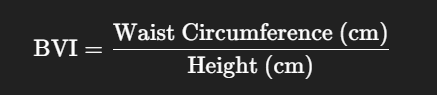

In [67]:
# Cell 9: Actual BVI vs Predicted BVI

# -----------------------------
# Actual BVI
# -----------------------------

# extract actual waist (inverse-scaled)
actual_waist = y_actual[0, target_cols.index("waist")]

# compute actual BVI
actual_bvi = actual_waist / height_cm

# -----------------------------
# Predicted BVI
# -----------------------------

# extract predicted waist from model output
predicted_waist = y_pred[0, target_cols.index("waist")]

# compute predicted BVI
predicted_bvi = predicted_waist / height_cm

# -----------------------------
# Display results
# -----------------------------

print("Actual BVI:", round(actual_bvi, 4))
print("Predicted BVI:", round(predicted_bvi, 4))


Actual BVI: 0.4684
Predicted BVI: 0.4954


Step 10: Actual vs Predicted Body Fat Percentage

since we doesn't have 'age' as a feature, we have to use the following formula

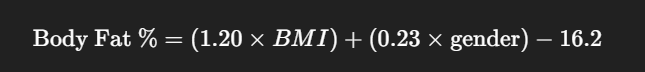

In [68]:
# Cell 10: Actual vs Predicted Body Fat Percentage (no age required)

# -----------------------------
# Gender
# -----------------------------

# extract gender from dataset (already encoded: male=1, female=0)
gender = data.loc[sample_index, "gender"]

# -----------------------------
# Actual Body Fat %
# -----------------------------

# compute actual body fat percentage using BMI-based formula
actual_body_fat = (
    1.20 * actual_bmi +
    0.23 * gender -
    16.2
)

# -----------------------------
# Predicted Body Fat %
# -----------------------------

# compute predicted body fat percentage using predicted BMI
predicted_body_fat = (
    1.20 * predicted_bmi +
    0.23 * gender -
    16.2
)

# -----------------------------
# Display results
# -----------------------------

print("Actual Body Fat %:", round(actual_body_fat, 2))
print("Predicted Body Fat %:", round(predicted_body_fat, 2))


Actual Body Fat %: 11.45
Predicted Body Fat %: 10.77


Step 12 : Fornt and Side image relted to the random selected record

In [69]:
# Cell 11: Print photo_id for selected sample

# extract photo_id of the selected sample
photo_id = data.loc[sample_index, "photo_id"]

# print photo_id
print("Selected photo_id:", photo_id)


Selected photo_id: 01b7f357ef9000d55e74891773d42d8a


In [70]:
# Cell 12: Define S3 paths for front and side masks

# S3 bucket where body mask images are stored
image_bucket = "amazon-bodym"

# S3 key for front mask image
front_mask_key = f"testA/mask/{photo_id}.png"

# S3 key for side (left) mask image
side_mask_key = f"testA/mask_left/{photo_id}.png"

# print paths for confirmation
print("Front mask S3 path:", front_mask_key)
print("Side mask S3 path:", side_mask_key)


Front mask S3 path: testA/mask/01b7f357ef9000d55e74891773d42d8a.png
Side mask S3 path: testA/mask_left/01b7f357ef9000d55e74891773d42d8a.png


In [71]:
# Cell 13: Load front and side mask images from S3

from PIL import Image      # image handling
import matplotlib.pyplot as plt
import io                  # in-memory byte stream

# reuse existing S3 client or create a new one
s3 = boto3.client("s3")

# -----------------------------
# Load front mask image
# -----------------------------
front_obj = s3.get_object(Bucket=image_bucket, Key=front_mask_key)
front_img = Image.open(io.BytesIO(front_obj["Body"].read()))

# -----------------------------
# Load side mask image
# -----------------------------
side_obj = s3.get_object(Bucket=image_bucket, Key=side_mask_key)
side_img = Image.open(io.BytesIO(side_obj["Body"].read()))


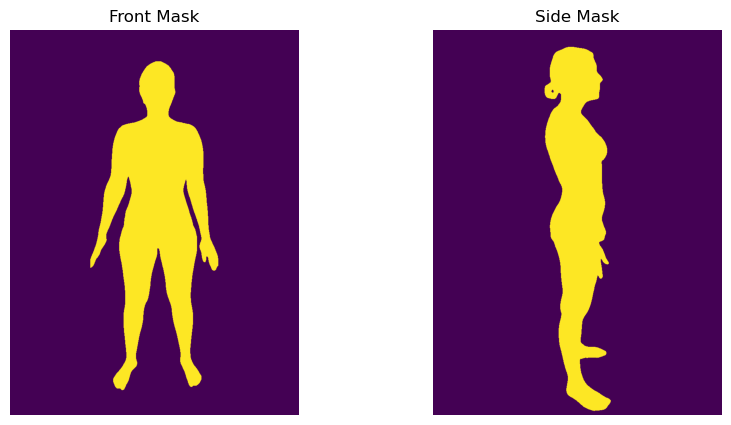

In [72]:
# Cell 14: Display front and side mask images

plt.figure(figsize=(10, 5))

# -----------------------------
# Front mask
# -----------------------------
plt.subplot(1, 2, 1)
plt.imshow(front_img)
plt.title("Front Mask")
plt.axis("off")

# -----------------------------
# Side mask
# -----------------------------
plt.subplot(1, 2, 2)
plt.imshow(side_img)
plt.title("Side Mask")
plt.axis("off")

plt.show()
